# BTC : Historical Prices

## Data source loading

In [1]:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

from math import sqrt

In [2]:
btc_yahoo = pd.read_csv('/home/giujorge/datalake/lab/Crypto/crypto/data/external/yahoo/daily/usd/BTC-USD.csv', parse_dates=True, index_col=0)
btc_yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [75]:
btc_yahoo.shape

(2546, 6)

In [76]:
btc_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2546 entries, 2014-09-17 to 2021-09-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2542 non-null   float64
 1   High       2542 non-null   float64
 2   Low        2542 non-null   float64
 3   Close      2542 non-null   float64
 4   Adj Close  2542 non-null   float64
 5   Volume     2542 non-null   float64
dtypes: float64(6)
memory usage: 139.2 KB


## Missing Values

In [77]:
btc_yahoo.isnull().sum()

Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [78]:
btc_yahoo[btc_yahoo['Open'].isnull()]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-09,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-12,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-13,NaN,NaN,NaN,NaN,NaN,NaN


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

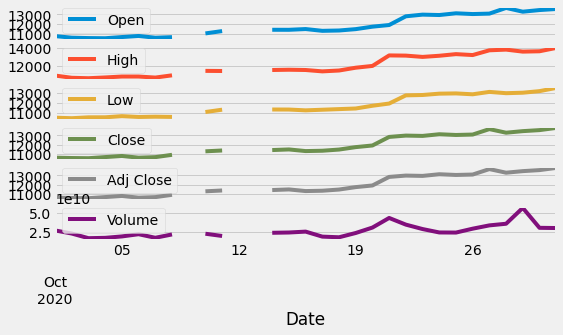

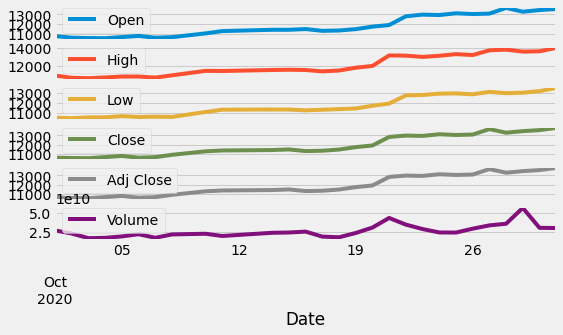

In [79]:
btc_yahoo.loc['2020-10'].plot(subplots=True, figsize=(8, 4))
btc_yahoo.loc['2020-10'].interpolate().plot(subplots=True, figsize=(8, 4))

In [3]:
btc_yahoo.interpolate(inplace=True)

In [81]:
btc_yahoo.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Descriptive Statistics

In [82]:
btc_yahoo.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2546.000000,2546.000000,2546.000000,2546.000000,2546.000000,2.546000e+03
mean,8772.057808,9022.047316,8502.551463,8791.041772,8791.041772,1.337391e+10
std,12926.973156,13322.204395,12481.796765,12950.946659,12950.946659,1.979516e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,574.170258,578.549500,569.250733,574.395996,574.395996,7.280068e+07
50%,5231.624512,5334.257080,5097.202637,5236.999024,5236.999024,4.345096e+09
75%,9526.624756,9701.644776,9325.418213,9526.807861,9526.807861,2.112313e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


## Visualization

### Plotting Lines

In [83]:
fig = go.Figure([go.Scatter(x=btc_yahoo.index, y=btc_yahoo['Adj Close'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='BTC : Historical Prices',
    template="simple_white",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Adj Close")
fig.show()

## Stationarity

In [6]:
def test_stationarity(timeseries):
    # Calculating rolling mean and rolling standard deviation:
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot statistics:
    plt.figure(figsize=(24,6))
    plt.plot(timeseries, color='blue', label='Rolling Original')
    plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=2.0)
    plt.plot(rolstd, color='green', label ='Rolling Std', linewidth=2.0)
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
 
    print('Results of dickey fuller test')
    adft_test = adfuller(timeseries, autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output_adf = pd.Series(adft_test[0:4],index=['ADF Statistic','p-value','No. of lags used','Number of observations used'])
    for key,values in adft_test[4].items():
        output_adf['critical value (%s)'%key] = values
    print(output_adf)

    print("KPSS Test:")
    kpss_test = kpss(timeseries, regression='c', nlags="auto", store=False)
    print('Null Hypothesis: Stationary')
    output_kpss = pd.Series(kpss_test[0:3],index=['ADF Statistic','p-value','No. of lags used'])
    for key,values in kpss_test[3].items():
        output_kpss['critical value (%s)'%key] = values
    print(output_kpss)


Results of dickey fuller test
Null Hypothesis: Not Stationary
ADF Statistic                     0.224413
p-value                           0.973598
No. of lags used                 27.000000
Number of observations used    2518.000000
critical value (1%)              -3.432950
critical value (5%)              -2.862689
critical value (10%)             -2.567381
dtype: float64
KPSS Test:
Null Hypothesis: Stationary
ADF Statistic             4.345678
p-value                   0.010000
No. of lags used         30.000000
critical value (10%)      0.347000
critical value (5%)       0.463000
critical value (2.5%)     0.574000
critical value (1%)       0.739000
dtype: float64


/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




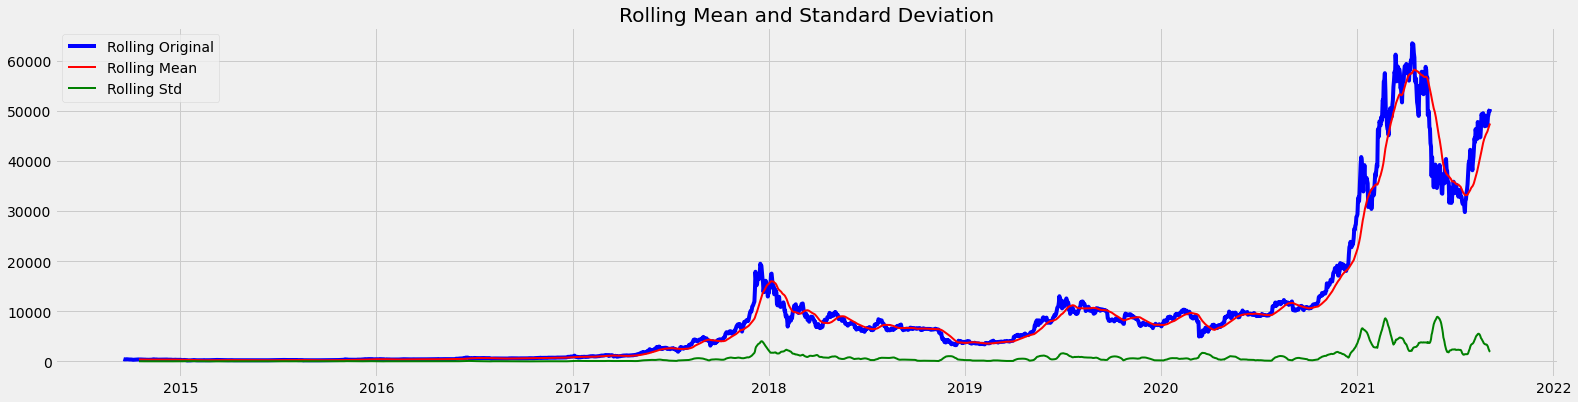

In [85]:
test_stationarity(btc_yahoo['Adj Close'])

### Decompose

<Figure size 432x288 with 0 Axes>

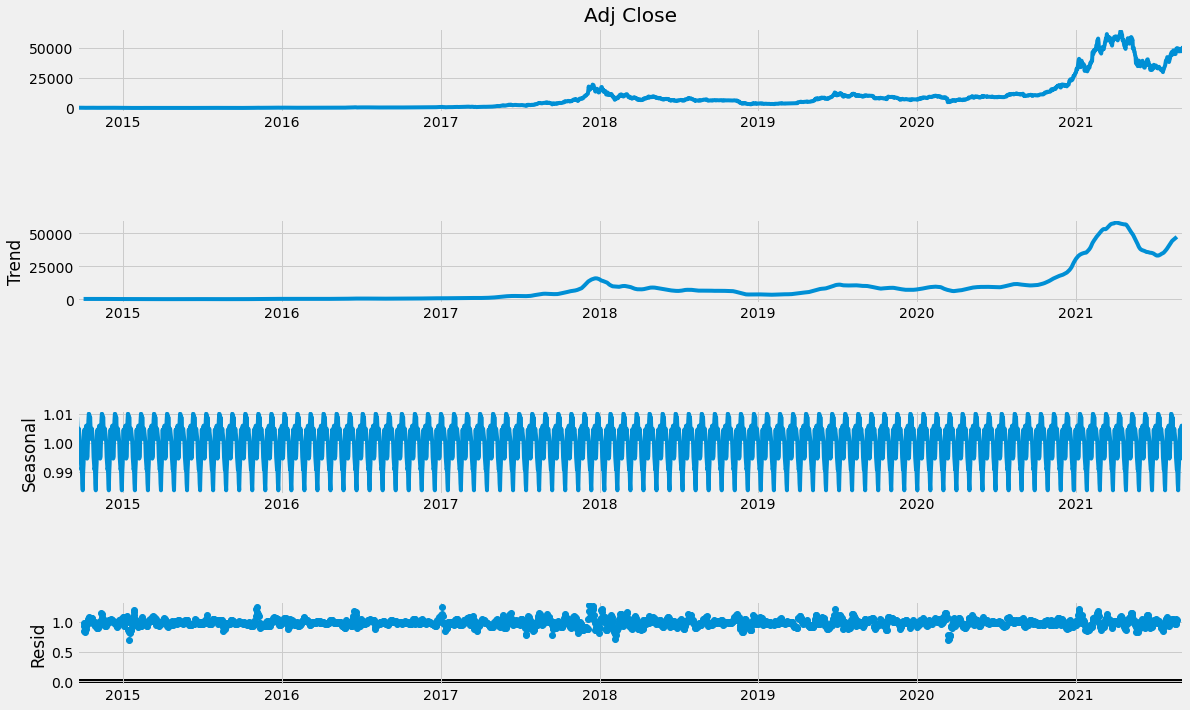

In [86]:
result = seasonal_decompose(btc_yahoo['Adj Close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)

## Tranform

In [87]:
btc_yahoo['Close_Detrend'] = (btc_yahoo['Adj Close'] - btc_yahoo['Adj Close'].shift(30))

Results of dickey fuller test
Null Hypothesis: Not Stationary
ADF Statistic                 -6.182465e+00
p-value                        6.405910e-08
No. of lags used               2.600000e+01
Number of observations used    2.489000e+03
critical value (1%)           -3.432980e+00
critical value (5%)           -2.862702e+00
critical value (10%)          -2.567389e+00
dtype: float64
KPSS Test:
Null Hypothesis: Stationary
ADF Statistic             0.355292
p-value                   0.096426
No. of lags used         29.000000
critical value (10%)      0.347000
critical value (5%)       0.463000
critical value (2.5%)     0.574000
critical value (1%)       0.739000
dtype: float64


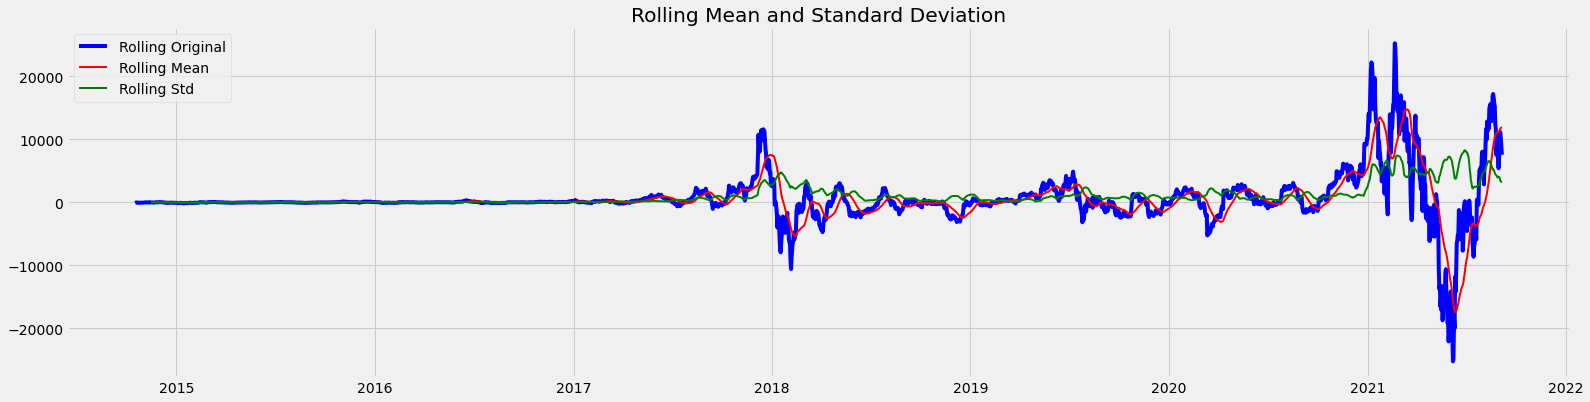

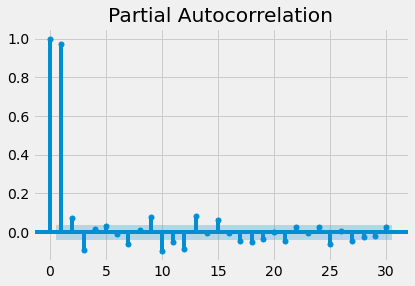

In [88]:
test_stationarity(btc_yahoo['Close_Detrend'].dropna())

pacf = plot_pacf(btc_yahoo['Close_Detrend'].dropna(), lags=30)

Results of dickey fuller test
Null Hypothesis: Not Stationary
ADF Statistic                 -8.089945e+00
p-value                        1.386931e-12
No. of lags used               2.000000e+01
Number of observations used    2.495000e+03
critical value (1%)           -3.432974e+00
critical value (5%)           -2.862699e+00
critical value (10%)          -2.567387e+00
dtype: float64
KPSS Test:
Null Hypothesis: Stationary
ADF Statistic             0.144989
p-value                   0.100000
No. of lags used         29.000000
critical value (10%)      0.347000
critical value (5%)       0.463000
critical value (2.5%)     0.574000
critical value (1%)       0.739000
dtype: float64


/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




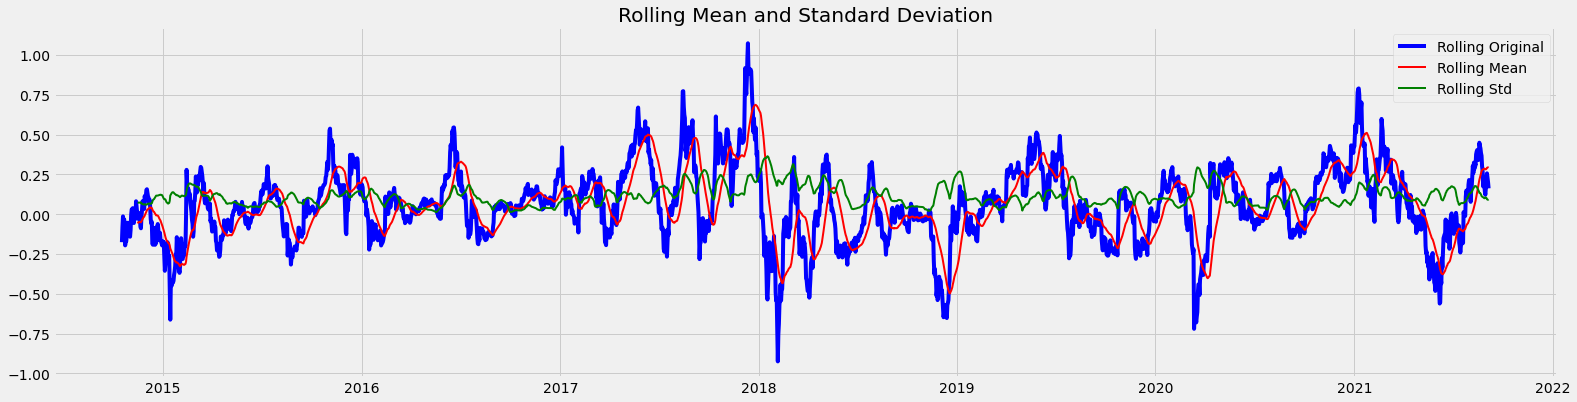

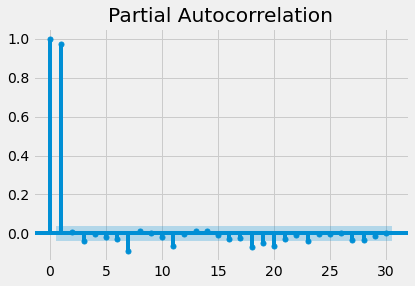

In [8]:
btc_yahoo_log = np.log(btc_yahoo['Adj Close'])

btc_yahoo['Close_Detrend_log'] = (btc_yahoo_log - btc_yahoo_log.shift(30))

test_stationarity(btc_yahoo['Close_Detrend_log'].dropna())

pacf = plot_pacf(btc_yahoo['Close_Detrend_log'].dropna(), lags=30)

## Model Building

### Splitting the Dataset

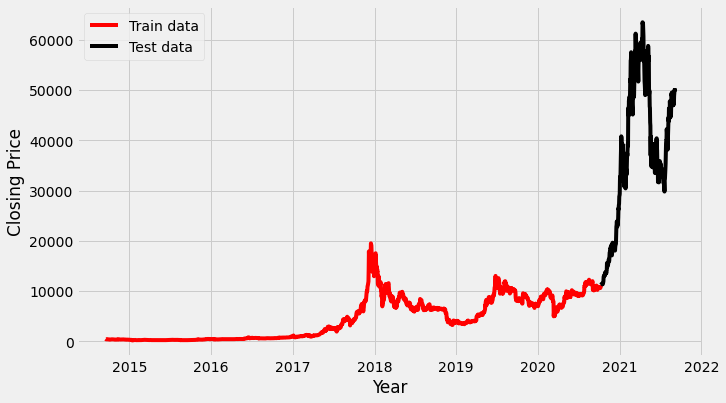

In [90]:
btc_yahoo_arima = btc_yahoo['Adj Close']
train_test_split_ratio = int(len(btc_yahoo_arima)*0.87)
train_data, test_data = btc_yahoo_arima[:train_test_split_ratio], btc_yahoo_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend()

### Auto-Regressive Integrated Moving Average (ARIMA)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31313.096, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31309.554, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31311.109, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31311.105, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31308.187, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2215
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -15653.093
Date:                Mon, 04 Oct 2021   AIC                          31308.187
Time:                        20:42:47   BIC                          31313.889
Sample:                             0   HQIC                         31310.270
                               - 2215                                  

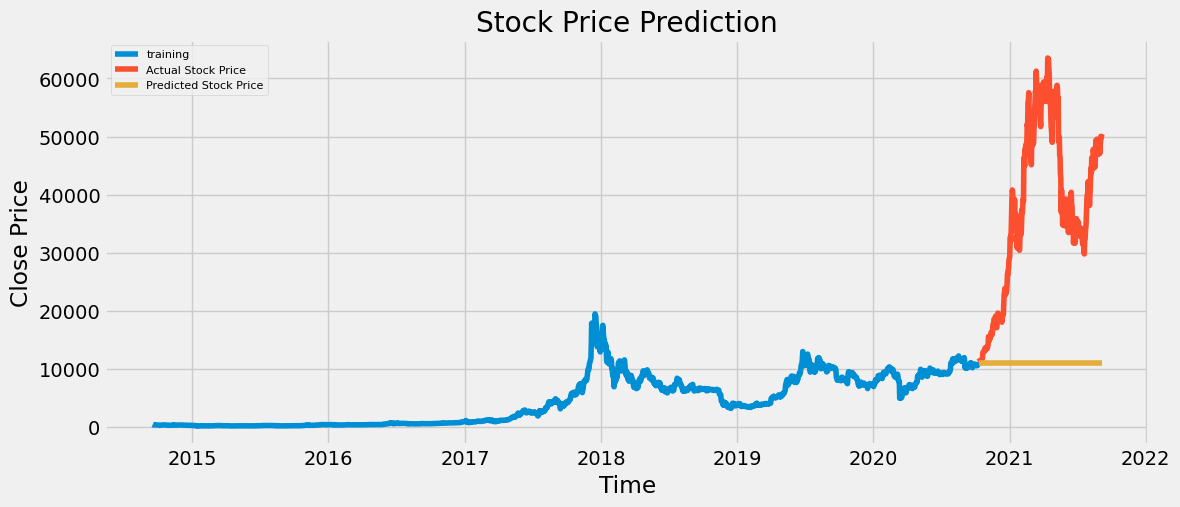

Auto-Arima RMSE :- 30322.796


In [91]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fitting the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting the values.
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

#Plotting the predicted stock price and original price.
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series,label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluating the model by calculating RMSE.
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



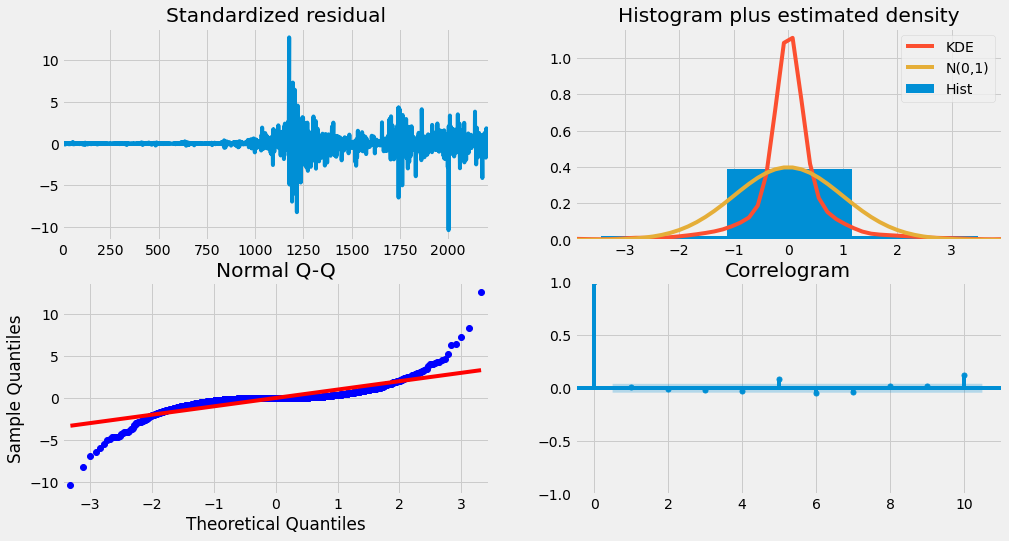

In [92]:
# Plotting the diagnostics of the fiited model.
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

### Holt’s Exponential Smoothing

In [93]:
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmode

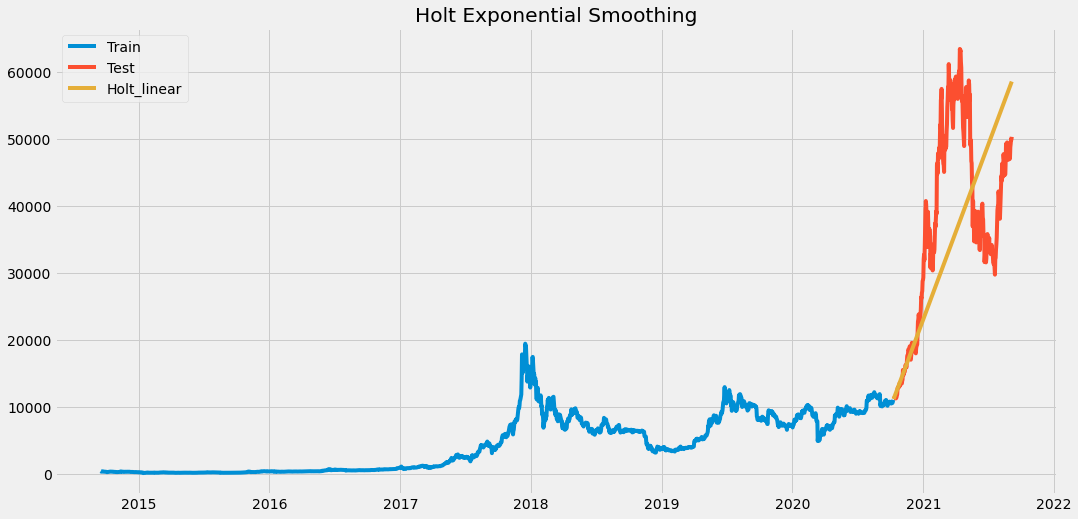

Holt’s Exponential Smoothing RMS :- 13241.447 & Smoothing Level :- 0.85 & Smoothing Slope :- 0.45


In [94]:
# Holt's Exponential Smoothing Method
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)


holt_linear_df = pd.DataFrame(columns = ['RMS','Smoothing Level','Smoothing Slope'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 2)
for i in list(perm):
  fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = i[0],smoothing_trend=i[1])
  pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear)),3)
  holt_linear_df = holt_linear_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0], 'Smoothing Slope':i[1]} , ignore_index=True)

opt_values = holt_linear_df.loc[holt_linear_df['RMS'] == min(holt_linear_df['RMS']),['Smoothing Level','Smoothing Slope']].values


# Using optimised values from the lists.
fit_holt = Holt(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0],smoothing_trend=opt_values[0][1])
pred_values['Holt_linear'] = fit_holt.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title('Holt Exponential Smoothing')
plt.show()

rms_holt_exp = sqrt(mean_squared_error(test_data.values, pred_values.Holt_linear))
print("Holt’s Exponential Smoothing RMS :- " + str(round(rms_holt_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)) + " & Smoothing Slope :- "+str(round(opt_values[0][1],3)))

In [95]:
# Printing RMSE of all the methods
print("RMSE of all the methods")
print("Auto-Arima:- " + str(round(rms_auto_arima,3)))
print("Holt’s Exponential Smoothing:- " + str(round(rms_holt_exp,3)))

RMSE of all the methods
Auto-Arima:- 30322.796
Holt’s Exponential Smoothing:- 13241.447


In [96]:
#Tranforme serial

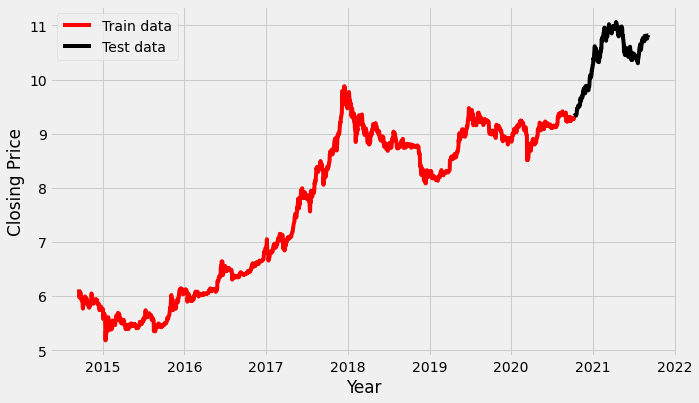

In [97]:
btc_yahoo_arima = btc_yahoo_log
train_test_split_ratio = int(len(btc_yahoo_arima)*0.87)
train_data, test_data = btc_yahoo_arima[:train_test_split_ratio], btc_yahoo_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8070.794, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8073.999, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8072.783, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8072.774, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8072.985, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.883 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2215
Model:               SARIMAX(0, 1, 0)   Log Likelihood                4039.000
Date:                Mon, 04 Oct 2021   AIC                          -8073.999
Time:                        20:43:10   BIC                          -8062.594
Sample:                             0   HQIC                         -8069.833
                               - 2215                                  

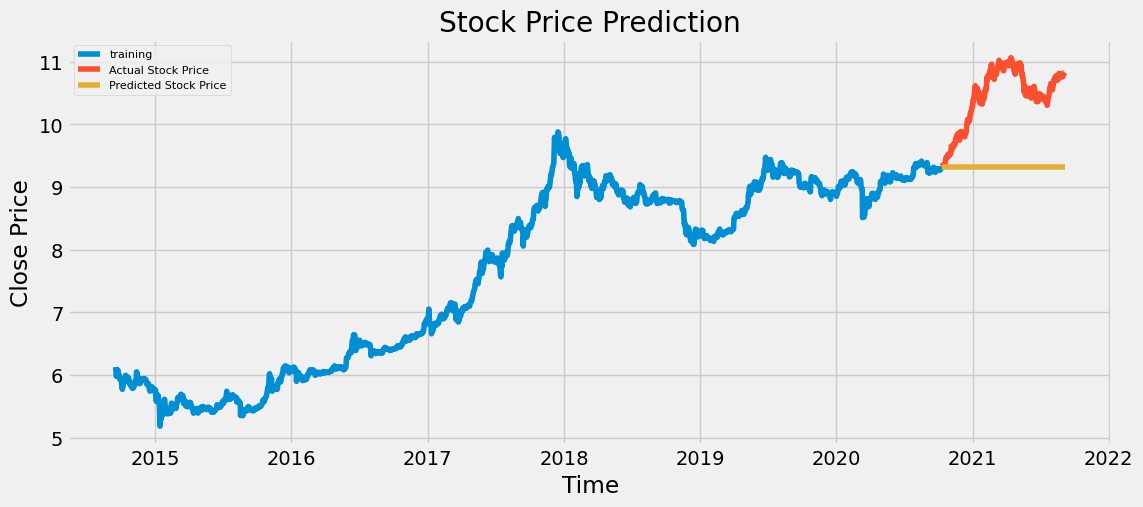

Auto-Arima RMSE :- 1.22


In [98]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fitting the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting the values.
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

#Plotting the predicted stock price and original price.
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series,label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluating the model by calculating RMSE.
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



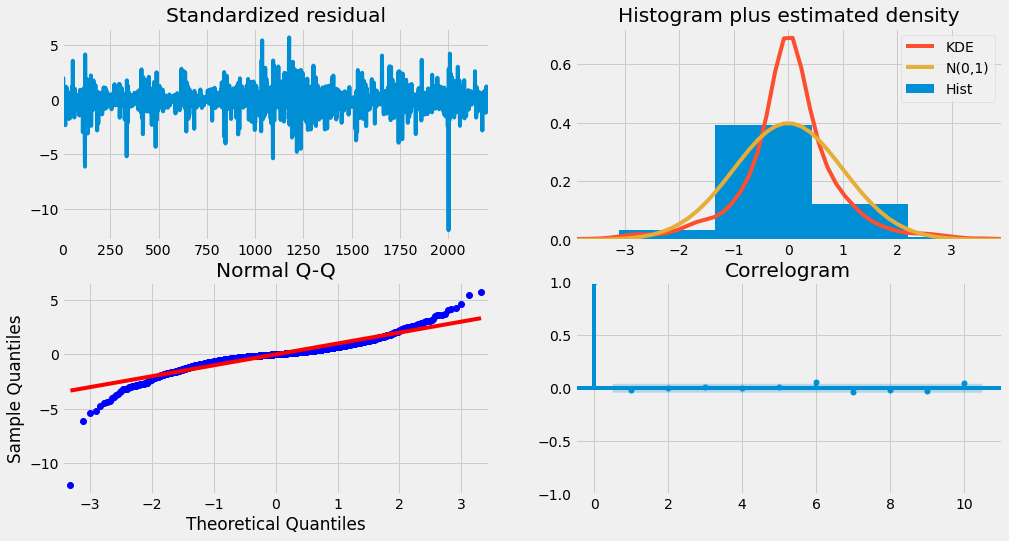

In [99]:
# Plotting the diagnostics of the fitted model.
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()

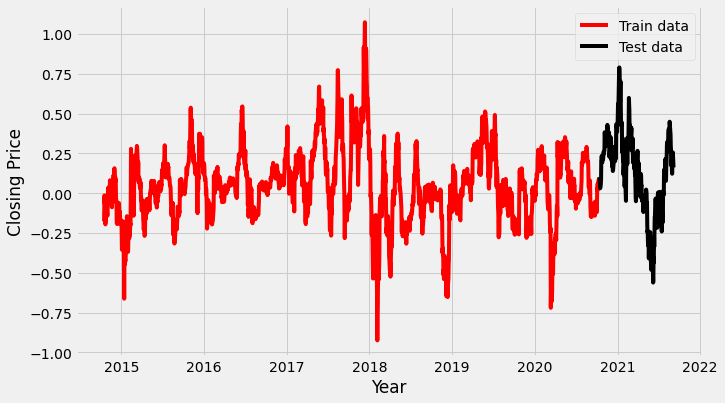

In [11]:
btc_yahoo_arima = btc_yahoo['Close_Detrend_log'].dropna()
train_test_split_ratio = int(len(btc_yahoo_arima)*0.87)
train_data, test_data = btc_yahoo_arima[:train_test_split_ratio], btc_yahoo_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6497.301, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-199.585, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6499.142, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2493.045, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6497.315, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6498.580, Time=0.87 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6498.344, Time=0.41 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.737 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2188
Model:               SARIMAX(1, 0, 0)   Log Likelihood                3251.571
Date:                Mon, 04 Oct 2021   AIC                          -6499.142
Time:                        20:47:55   BIC                          -6487.761
Sample:          

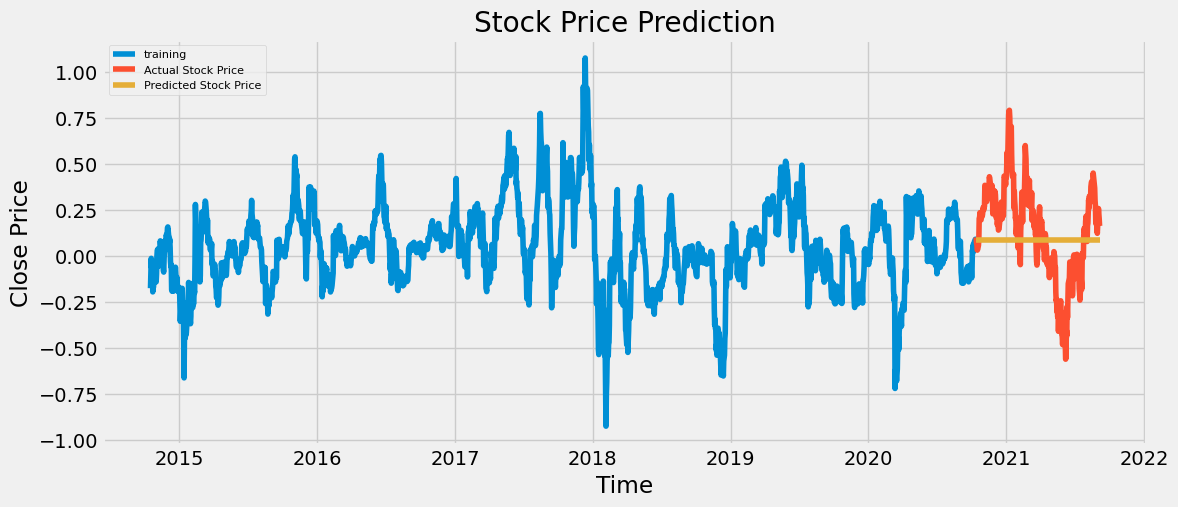

Auto-Arima RMSE :- 0.259


In [12]:
# Auto ARIMA Method
arima_model = auto_arima(train_data,
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      test='adf',        
                      trace=True,
                      alpha=0.05,
                      scoring='mse',
                      suppress_warnings=True,
                      seasonal = False
                      )

# Fitting the final model with the order
fitted_model = arima_model.fit(train_data) 
print(fitted_model.summary())

# Forecasting the values.
forecast_values = fitted_model.predict(len(test_data), alpha=0.05) 
fcv_series = pd.Series(forecast_values[0], index=test_data.index)

#Plotting the predicted stock price and original price.
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fcv_series,label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Evaluating the model by calculating RMSE.
rms_auto_arima = sqrt(mean_squared_error(test_data.values, fcv_series))
print("Auto-Arima RMSE :- " + str(round(rms_auto_arima,3)))

/home/giujorge/miniconda3/envs/crypto/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



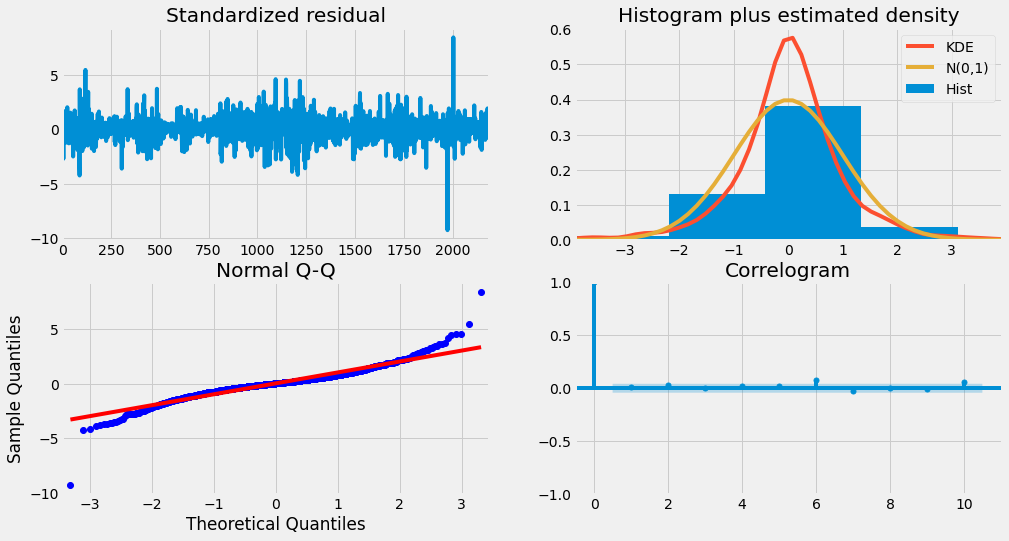

In [13]:
# Plotting the diagnostics of the fiited model.
arima_model.plot_diagnostics(figsize=(15,8))
plt.show()